In [14]:
using PyCall
using Printf
using Dates
using LinearAlgebra
# Force BLAS to use 1 thread, allowing Julia threads to manage parallelism
BLAS.set_num_threads(1)

# 1. Load your local PolyhedraTree module
include("../gb_julia/PolyhedraTree.jl")
using .PolyhedraTree

# 2. Setup Python Environment
# Add current directory to Python path so we can find 'src_experiment'
sys = pyimport("sys")
pushfirst!(PyVector(sys."path"), "../")

# Import python libraries
torch = pyimport("torch")
src_exp = pyimport("src_experiment") # Equivalent to: import src_experiment

# Define helper to convert PyTorch state dict to Julia Dict
function convert_torch_state(py_state)
    jl_dict = Dict{String, Any}()
    for (k, v) in py_state
        # Convert Tensor -> Numpy -> Julia Array
        if pyisinstance(v, torch.Tensor)
            jl_dict[String(k)] = v.detach().cpu().numpy()
        else
            jl_dict[String(k)] = v
        end
    end
    return jl_dict
end

function main()
    # 1. Get the path object from Python
    base_path_py = src_exp.get_test_data().absolute()
    
    # --- FIX HERE ---
    # use .as_posix() to get a clean string explicitly
    base_path = base_path_py.as_posix()
    
    println("Current Working Directory: $(pwd())")
    println("Base Data Path resolved to: $base_path")

    epochs = [0, 10, 20, 30, 40]
    trees = Dict{Int, Any}()
    
    tot_start = time()
    
    for epoch in epochs
        # Construct path safely using Julia's joinpath on the clean string
        state_dict_path = joinpath(base_path, "state_dicts", "epoch$(epoch).pth")
        
        if !isfile(state_dict_path)
            println("\n!!! ERROR: File not found: $state_dict_path")
            println("Please check if the folder structure matches this path.")
            continue 
        end
        
        println("Loading: $state_dict_path")
        
        # Load using torch
        raw_state = torch.load(state_dict_path, map_location="cpu")
        state = convert_torch_state(raw_state)
        
        start_t = time()
        println("--- Epoch $epoch ---")
        
        # New:
        tree = PolyhedraTree.Tree(state)
        PolyhedraTree.construct_tree!(tree, verbose=true)
        trees[epoch] = tree
        
        end_t = time()
        @printf("Duration: %.2f s\n", end_t - start_t)
    end
    
    tot_end = time()
    @printf("Total duration: %.2f s\n", tot_end - tot_start)
    
    return trees
end


# Ensure multi-threading is on
if Threads.nthreads() == 1
    println("Warning: Running on 1 thread. Run with 'julia --threads auto main.jl' for speed.")
end
# println(Threads.nthreads())

trees = main()


Current Working Directory: /home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks
Base Data Path resolved to: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch0.pth
--- Epoch 0 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:00
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:02
Layer 5: 100%|██████████████████████████████████████████| Time: 0:00:03


Duration: 7.52 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch10.pth
--- Epoch 10 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:01
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:02
Layer 5: 100%|██████████████████████████████████████████| Time: 0:00:03


Duration: 8.15 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch20.pth
--- Epoch 20 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:00
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:02
Layer 5: 100%|██████████████████████████████████████████| Time: 0:00:03


Duration: 7.42 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch30.pth
--- Epoch 30 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:00
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:03
Layer 5: 100%|██████████████████████████████████████████| Time: 0:00:03


Duration: 7.73 s
Loading: /home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/testing/state_dicts/epoch40.pth
--- Epoch 40 ---


Layer 3: 100%|██████████████████████████████████████████| Time: 0:00:00
Layer 4: 100%|██████████████████████████████████████████| Time: 0:00:02
Layer 5: 100%|██████████████████████████████████████████| Time: 0:00:03


Duration: 6.92 s
Total duration: 37.82 s


Dict{Int64, Any} with 5 entries:
  0  => Tree([[-1.70397 -1.37745; -0.731534 -1.64136; … ; -1.54512 -0.138452; -…
  20 => Tree([[-1.64885 -1.32406; -0.490673 -1.56688; … ; -1.67716 -0.195048; -…
  10 => Tree([[-1.5873 -1.35169; -0.485231 -1.61533; … ; -1.62433 -0.201899; -1…
  30 => Tree([[-1.71614 -1.26203; -0.498398 -1.50396; … ; -1.68549 -0.0931023; …
  40 => Tree([[-1.72089 -1.26411; -0.440765 -1.45877; … ; -1.71444 0.114353; -0…

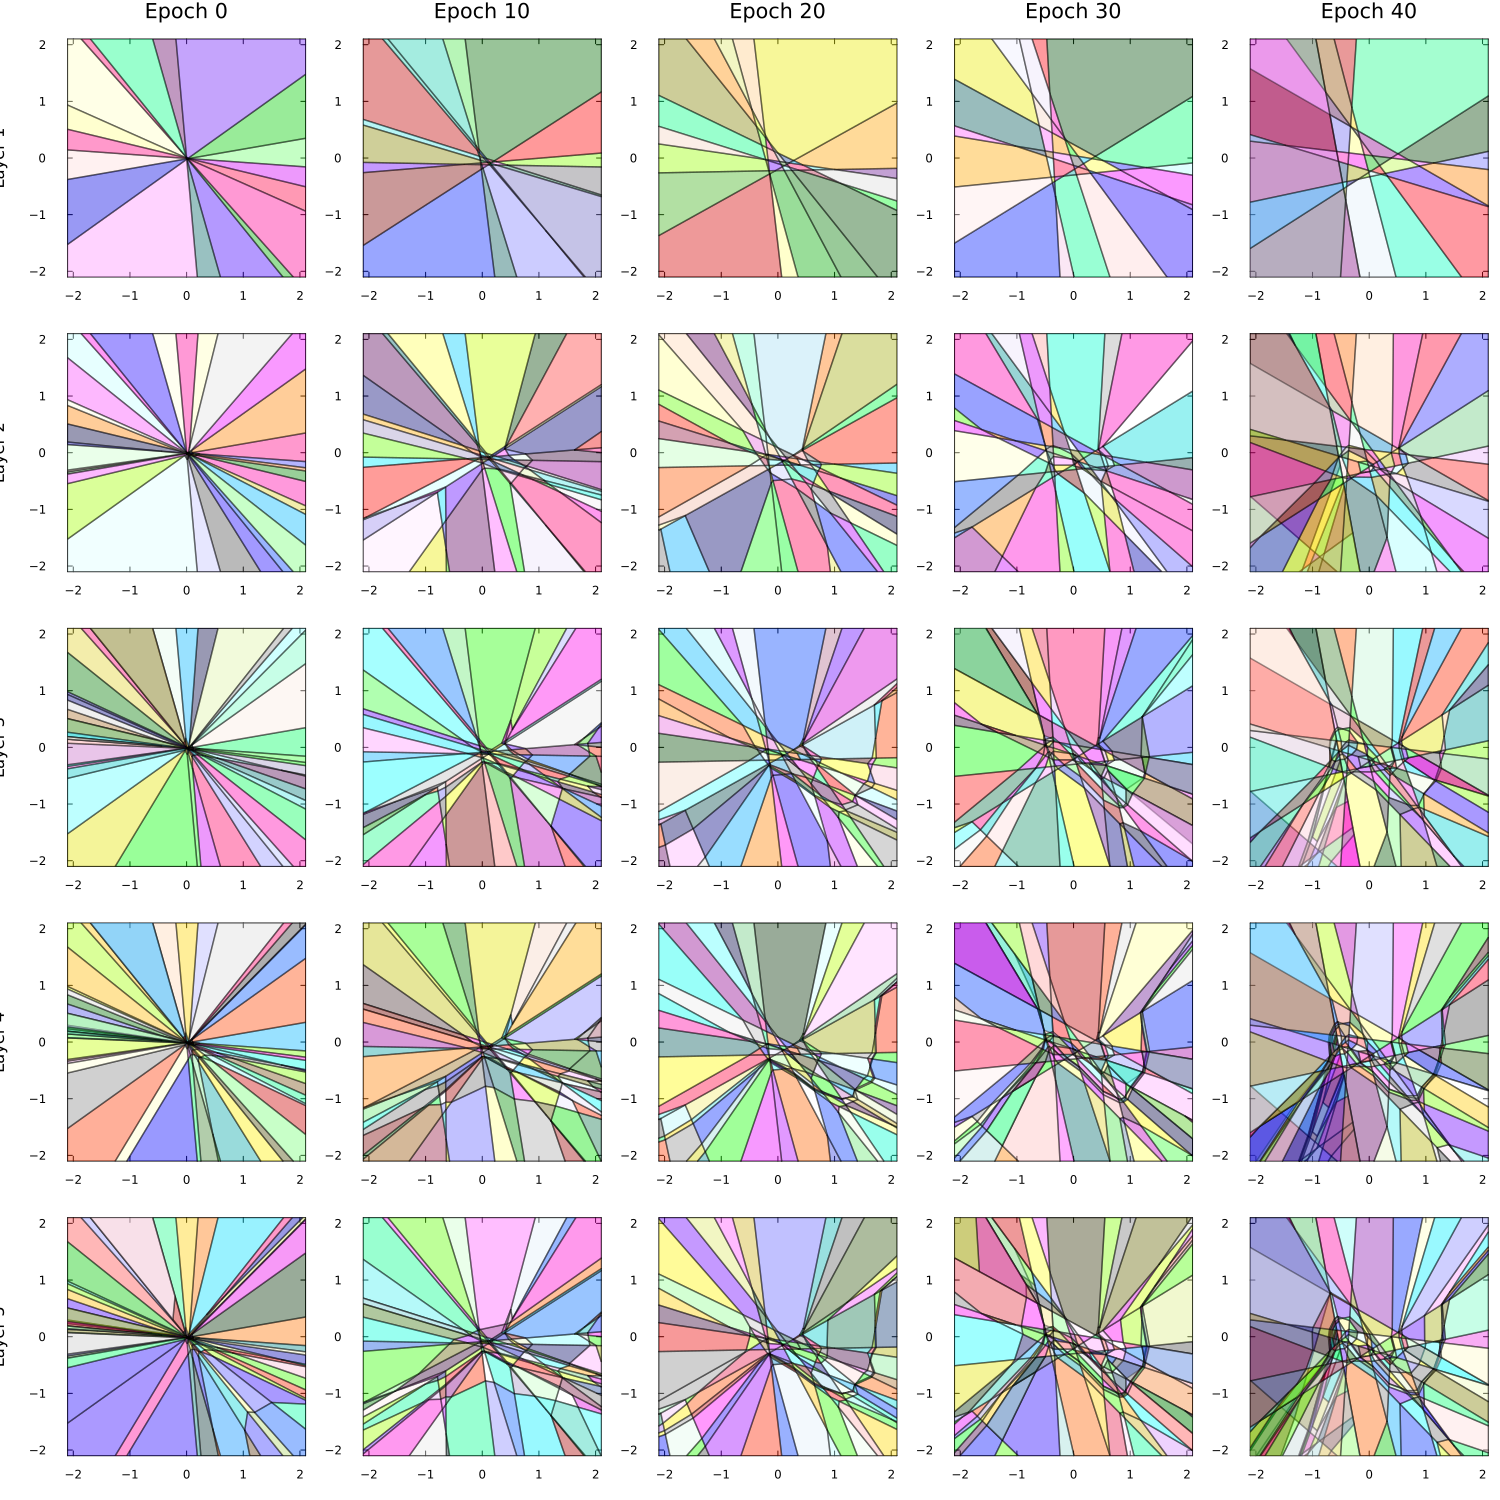

In [15]:
using Polyhedra
using CDDLib      # The backend solver (C-library)
using Plots
using Colors
using LinearAlgebra

# 1. Helper to create a bounded polyhedron from a Region
function get_bounded_polyhedron(region; bound=2000)
    # Get the inequalities from your struct: Dlw * x <= glw
    # We explicitly copy them to ensure we don't mutate the tree
    A, b = PolyhedraTree.get_path_inequalities(region)
    
    # Dimensions
    dim = size(A, 2)
    
    # Create Bounding Box Constraints: -bound <= x <= bound
    # This is equivalent to:  I*x <= bound  AND -I*x <= bound
    I_mat = Matrix{Float64}(I, dim, dim)
    
    A_box = vcat(I_mat, -I_mat)      # Stack identity and negative identity
    b_box = fill(bound, 2 * dim)     # Vector of [bound, bound, ...]
    
    # Combine Region constraints with Box constraints
    A_full = vcat(A, A_box)
    b_full = vcat(b, b_box)
    
    # Create the Polyhedron using CDDLib
    # H-representation: {x | Ax <= b}
    h = hrep(A_full, b_full)
    poly = polyhedron(h, CDDLib.Library())
    
    # Compute vertices (V-representation) to check if empty/valid
    # removevredundancy! triggers the computation of vertices
    try
        removevredundancy!(poly)
        if isempty(poly)
            return nothing
        end
        return poly
    catch e
        return nothing
    end
end

# 2. Main Plotting Function
function plot_epoch_layer_grid(trees; bound=10)
    epochs = sort(collect(keys(trees)))
    num_epochs = length(epochs)
    
    # Assume all trees have same depth
    num_layers = trees[epochs[1]].L
    
    # Setup the plot layout (Grid: Layers x Epochs)
    # layout = @layout [grid(num_layers, num_epochs)]
    
    # Initialize a large plot object with subplots
    p = plot(layout = (num_layers, num_epochs), 
             size = (num_epochs * 300, num_layers * 300),
             legend = false,
             framestyle = :box)

    for (col, epoch) in enumerate(epochs)
        tree = trees[epoch]
        
        for layer in 1:num_layers
            # Calculate subplot index (linear indexing in Julia Plots)
            # Row `layer`, Column `col`
            subplot_idx = (layer - 1) * num_epochs + col
            
            # Formatting (Titles and Labels)
            if layer == 1
                plot!(p[subplot_idx], title="Epoch $epoch")
            end
            if col == 1
                plot!(p[subplot_idx], ylabel="Layer $layer")
            end
            
            # Set limits and aspect ratio
            plot!(p[subplot_idx], 
                  xlims=(-bound, bound), 
                  ylims=(-bound, bound), 
                  aspect_ratio=:equal,
                  grid=false)

            # Get regions and plot them
            # Note: Explicitly calling PolyhedraTree module if needed
            regions = PolyhedraTree.get_regions_at_layer(tree, layer)
            
            for region in regions
                poly = get_bounded_polyhedron(region)
                
                if !isnothing(poly)
                    # Plots.jl has a recipe for Polyhedra. 
                    # It handles the triangulation/polygon creation automatically.
                    # Inside your plotting loop:
                    plot!(p[subplot_idx], poly, 
                        color = rand(RGB), 
                        alpha = 0.4,          # Lower alpha makes overlaps appear darker
                        linecolor = :black, 
                        linewidth = 1.5)      # Thicker lines show the partition structure better
                                    end
            end
        end
    end
    
    return p
end

# Usage:
plt = plot_epoch_layer_grid(trees, bound=2.1)
display(plt)
# savefig(plt, "grid_visualization.png")

In [16]:
hidden_sizes = [0, 9, 7, 5, 3, 1]

# In Julia, cumsum works similarly but exponentiation is element-wise with .^
n_theo_all = 2 .^ cumsum(hidden_sizes)

t0 = trees[0]

for i in 1:t0.L
    # Julia is 1-indexed, so we access layer i directly
    regions_in_layer = PolyhedraTree.get_regions_at_layer(t0, i)
    n_new = length(regions_in_layer)
    
    # Access the theoretical number. Note: hidden_sizes had a 0 at index 1,
    # so index i+1 in n_theo_all corresponds to layer i.
    n_theo = n_theo_all[i + 1]
    
    println("\nLayer: $i\nRegions (new): $n_new\nRegions (tot): $n_theo\n")
end


Layer: 1
Regions (new): 46
Regions (tot): 512


Layer: 2
Regions (new): 137
Regions (tot): 65536


Layer: 3
Regions (new): 1101
Regions (tot): 2097152


Layer: 4
Regions (new): 2724
Regions (tot): 16777216


Layer: 5
Regions (new): 4855
Regions (tot): 33554432



In [17]:
using LinearAlgebra
using ProgressMeter
using Statistics  # <--- This fixes the UndefVarError

function check_overlaps(tree, layer_idx; method=:center, tol=1e-6)
    println("\n--- Checking Overlaps for Layer $layer_idx ---")
    
    regions = PolyhedraTree.get_regions_at_layer(tree, layer_idx)
    n = length(regions)
    println("Found $n regions. Preparing geometry...")
    
    region_data = []
    
    @showprogress for r in regions
        # Get full path constraints
        A, b = PolyhedraTree.get_path_inequalities(r)
        
        # Calculate a representative interior point
        poly = get_bounded_polyhedron(r, bound=10.0)
        
        if isnothing(poly) || isempty(poly)
            push!(region_data, nothing)
            continue
        end
        
        verts = collect(points(vrep(poly)))
        if isempty(verts)
            push!(region_data, nothing)
            continue
        end
        
        # Compute centroid (average of vertices)
        # This function now works because Statistics is loaded
        center = mean(verts)
        
        push!(region_data, (A=A, b=b, center=center, id=r.qlw))
    end
    
    # 2. Check for Overlaps
    overlap_count = 0
    overlapping_pairs = Set{Tuple{Int, Int}}()
    
    println("Testing intersections...")
    
    for i in 1:n
        data_i = region_data[i]
        isnothing(data_i) && continue
        
        center_i = data_i.center
        
        for j in 1:n
            i == j && continue 
            
            data_j = region_data[j]
            isnothing(data_j) && continue
            
            # Check: Is center_i satisfying constraints of region j?
            violation = data_j.A * center_i - data_j.b
            
            # If max violation is negative, point is INSIDE
            if maximum(violation) < -tol
                pair = minmax(i, j)
                if !(pair in overlapping_pairs)
                    push!(overlapping_pairs, pair)
                    overlap_count += 1
                    if overlap_count <= 5
                        println("  !! Overlap detected: Region $i and Region $j")
                    end
                end
            end
        end
    end
    
    if overlap_count == 0
        println("✅ No interior overlaps detected.")
    else
        println("❌ Found $overlap_count overlapping pairs!")
    end
    
    return overlap_count
end

check_overlaps (generic function with 1 method)

In [18]:

for layer in 1:5
    check_overlaps(trees[0], layer) # Check epoch 0, layer 2
end



--- Checking Overlaps for Layer 1 ---
Found 46 regions. Preparing geometry...
Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 2 ---
Found 137 regions. Preparing geometry...
Testing intersections...
✅ No interior overlaps detected.

--- Checking Overlaps for Layer 3 ---
Found 1101 regions. Preparing geometry...
Testing intersections...
  !! Overlap detected: Region 303 and Region 310
  !! Overlap detected: Region 315 and Region 310
  !! Overlap detected: Region 506 and Region 508
  !! Overlap detected: Region 655 and Region 656
  !! Overlap detected: Region 921 and Region 923
❌ Found 8 overlapping pairs!

--- Checking Overlaps for Layer 4 ---
Found 2724 regions. Preparing geometry...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Testing intersections...
  !! Overlap detected: Region 748 and Region 759
  !! Overlap detected: Region 760 and Region 770
  !! Overlap detected: Region 770 and Region 759
  !! Overlap detected: Region 1285 and Region 1292
  !! Overlap detected: Region 1651 and Region 1656
❌ Found 11 overlapping pairs!

--- Checking Overlaps for Layer 5 ---
Found 4855 regions. Preparing geometry...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Testing intersections...
  !! Overlap detected: Region 1339 and Region 1361
  !! Overlap detected: Region 1360 and Region 1339
  !! Overlap detected: Region 1362 and Region 1382
  !! Overlap detected: Region 1382 and Region 1360
  !! Overlap detected: Region 2244 and Region 2257
❌ Found 18 overlapping pairs!
